# **Credit Card Fraud Detection Predictive Models - Methodology Assignment**



*   Kathy Agafonov, 206332348
*   Noam Tarshish, 207761024
*   Niv Sampson, 208398511
*   Mor Barzilay, 313322380



The assignment based on the link: https://www.kaggle.com/code/fatinisraqtabib/credit-card-fraud-detection/notebook

## **Installs and Imports**

In [ ]:
!pip install matplotlib pandas
!pip install networkx
!pip install torch-geometric
!pip install torch torchvision torchaudio
!pip install scipy==1.7.3
!pip install networkx --upgrade
!pip install torch torchvision

  Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 34.3/34.3 MB 46.7 MB/s eta 0:00:00
Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
lightning 2.0.2 requires fastapi<0.89.0,>=0.69.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.
tensorflow-intel 2.17.0 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 1.22.4 which is incompatible.


In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import IsolationForest

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import functional as F

import xgboost as xgb

import networkx as nx

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import time

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_curve, auc


## **1. Data Collection**

### Load the dataset from csv

In [ ]:
# Load the dataset from the CSV file
# file_path = '/content/small_fraudTrain.csv'
file_path = 'fraudTrain.csv'

df = pd.read_csv(file_path)

# Verify total number of records
print("Total number of records in the dataset:", len(df))

# Count of fraudulent and non-fraudulent transactions
label_counts = df['is_fraud'].value_counts()

print("Fraudulent transactions:", label_counts[1])
print("Non-fraudulent transactions:", label_counts[0])


Total number of records in the dataset: 1296675
Fraudulent transactions: 7506
Non-fraudulent transactions: 1289169


## **2. Data Cleaning**

### Hande Unbalanced data

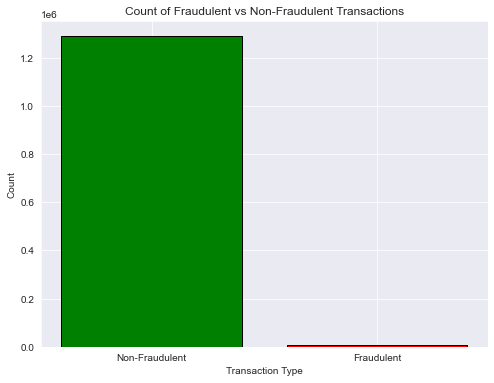

In [ ]:
# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['green', 'red'], edgecolor='black')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.title('Count of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

We can see that our data is not balanced. Because we have a lot of data from the small class as well, we chose to use Downsampling method to compare the records from the two classes

In [ ]:
# Separate majority and minority classes
df_majority = df[df.is_fraud == 0]
df_minority = df[df.is_fraud == 1]

# Display counts to verify
print("\nBefore balancing the data:")
print("Fraudulent transactions:", len(df_minority))
print("Non-fraudulent transactions:", len(df_majority))

# Undersample the majority class
df_majority_undersampled = df_majority.sample(len(df_minority), random_state=42)

# Combine the undersampled majority class with the minority class
df_balanced = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the combined dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the balance of the dataset

print("\nAfter balancing the data:")
print("Count of records labeled as 1 (fraudulent):", df_balanced['is_fraud'].sum())
print("Count of records labeled as 0 (non-fraudulent):", len(df_balanced) - df_balanced['is_fraud'].sum())

print("Data shape:", df_balanced.shape)


Before balancing the data:
Fraudulent transactions: 7506
Non-fraudulent transactions: 1289169

After balancing the data:
Count of records labeled as 1 (fraudulent): 7506
Count of records labeled as 0 (non-fraudulent): 7506
Data shape: (15012, 23)


### Handle missing values

In [ ]:
# Check for missing values
missing_values = df_balanced.isnull().sum()
print("Missing values in each column:")
print("------------------------------")
print(missing_values)

Missing values in each column:
------------------------------
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


It can be seen that there are no missing values ​​and therefore there is no need to handle missing values

### Remove Duplicates

In [ ]:
print("Data shape before dropping duplicates:", df_balanced.shape)
df_balanced.drop_duplicates(inplace=True)

print("Data shape after dropping duplicates:", df_balanced.shape)

Data shape before dropping duplicates: (15012, 23)
Data shape after dropping duplicates: (15012, 23)


It can be seen that there were no duplicate records

### Correcting data types and inconsistencies

Identify Current Data Types

In [ ]:
print("\nData types before correction:")
print(df_balanced.dtypes)


Data types before correction:
Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


Correct data types or inconsistencies

In [ ]:
# Correct data types or inconsistencies
df_balanced['cc_num'] = df_balanced['cc_num'].astype(str)  # Credit card numbers as strings

# Ensure 'trans_date_trans_time' exists and convert to datetime
if 'trans_date_trans_time' in df_balanced.columns:
    df_balanced['trans_date_trans_time'] = pd.to_datetime(df_balanced['trans_date_trans_time'])
else:
    print("Column 'trans_date_trans_time' not found in the DataFrame.")

df_balanced['merchant'] = df_balanced['merchant'].str.strip().str.lower()
df_balanced['category'] = df_balanced['category'].astype(str).str.lower().str.replace(' ', '_')
df_balanced['amt'] = df_balanced['amt'].astype(float)
df_balanced['first'] = df_balanced['first'].astype(str)
df_balanced['last'] = df_balanced['last'].astype(str)
df_balanced['gender'] = df_balanced['gender'].astype(str)
df_balanced['street'] = df_balanced['street'].astype(str)
df_balanced['city'] = df_balanced['city'].astype(str)
df_balanced['state'] = df_balanced['state'].astype(str)
df_balanced['zip'] = df_balanced['zip'].astype(str)
df_balanced['lat'] = df_balanced['lat'].astype(float)
df_balanced['long'] = df_balanced['long'].astype(float)
df_balanced['city_pop'] = df_balanced['city_pop'].astype(int)
df_balanced['job'] = df_balanced['job'].astype(str)

# Ensure 'dob' exists and convert to datetime
if 'dob' in df_balanced.columns:
    df_balanced['dob'] = pd.to_datetime(df_balanced['dob'])
else:
    print("Column 'dob' not found in the DataFrame.")

df_balanced['trans_num'] = df_balanced['trans_num'].astype(str)
df_balanced['unix_time'] = df_balanced['unix_time'].astype(int)
df_balanced['merch_lat'] = df_balanced['merch_lat'].astype(float)
df_balanced['merch_long'] = df_balanced['merch_long'].astype(float)
df_balanced['is_fraud'] = df_balanced['is_fraud'].astype(int)

In [ ]:
print("\nData types after correction:")
print(df_balanced.dtypes)


Data types after correction:
Unnamed: 0                        int64
trans_date_trans_time    datetime64[ns]
cc_num                           object
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                              object
lat                             float64
long                            float64
city_pop                          int32
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int32
merch_lat                       float64
merch_long                      float64
is_fraud                          int32
dtype: object


### Before and After Cleaning

In [ ]:
# Print summaries
print("\nSummary before cleaning:")
print("Class distribution before cleaning:")
print(df['is_fraud'].value_counts())
print("\nMissing values before cleaning:\n", df.isnull().sum())
print("\nBasic statistics before cleaning:")
display(df.describe())

print("\nSummary after cleaning:")
print("Class distribution after cleaning:")
print(df_balanced['is_fraud'].value_counts())
print("\nMissing values after cleaning:\n", df_balanced.isnull().sum())
print("\nBasic statistics after cleaning:")
display(df_balanced.describe())

# Display the first few rows of both DataFrames for a quick visual comparison
print("\nFirst few rows of raw data (before cleaning):")
display(df.head())

print("\nFirst few rows of cleaned data (after cleaning):")
display(df_balanced.head())


Summary before cleaning:
Class distribution before cleaning:
0    1289169
1       7506
Name: is_fraud, dtype: int64

Missing values before cleaning:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Basic statistics before cleaning:


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00



Summary after cleaning:
Class distribution after cleaning:
0    7506
1    7506
Name: is_fraud, dtype: int64

Missing values after cleaning:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Basic statistics after cleaning:


,Unnamed: 0,amt,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.501200e+04,15012.000000,15012.000000,15012.000000,1.501200e+04,1.501200e+04,15012.000000,15012.000000,15012.000000
mean,6.365042e+05,299.517998,38.620164,-90.275251,9.051075e+04,1.348818e+09,38.612480,-90.275455,0.500000
std,3.873911e+05,373.915804,5.128513,14.084930,3.035544e+05,1.332573e+07,5.168227,14.105491,0.500017
min,5.500000e+02,1.000000,20.027100,-165.672300,2.300000e+01,1.325402e+09,19.041880,-166.550779,0.000000
25%,2.839260e+05,20.497500,34.778900,-96.983700,7.430000e+02,1.337471e+09,34.896843,-96.989761,0.000000
50%,6.382690e+05,89.545000,39.405500,-87.410100,2.526000e+03,1.348876e+09,39.403182,-87.360104,0.500000
75%,9.813065e+05,477.102500,42.015800,-80.128400,2.112500e+04,1.359844e+09,41.991035,-80.168734,1.000000
max,1.296552e+06,6337.250000,66.693300,-67.950300,2.906700e+06,1.371813e+09,67.510267,-67.027467,1.000000



First few rows of raw data (before cleaning):


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0



First few rows of cleaned data (after cleaning):


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,1173129,2020-05-04 18:52:50,375848982312810,"fraud_ledner, hartmann and feest",health_fitness,10.14,Dale,Smith,M,25036 Contreras Turnpike Suite 270,...,31.4841,-97.9903,258,Web designer,1943-12-15,3879813e90ed30c5d3319964d9ae0936,1367693570,31.451097,-97.303447,0
1,314369,2019-06-01 03:52:32,4777065439639721,fraud_zemlak group,misc_net,87.96,Peter,Caldwell,M,08966 Beltran Route Suite 905,...,40.1334,-75.4536,737,Oceanographer,1987-04-24,c17fbc0337fcc01a65801b42f714a030,1338522752,40.812810,-75.959901,0
2,65991,2019-02-08 22:34:34,4488258847705225890,fraud_jast ltd,shopping_net,929.06,Jessica,Shaw,F,5745 Blair Locks,...,33.9568,-81.1405,52126,Chemical engineer,1929-08-23,55754c02f5f6c0d105ce5e34a9d726ea,1328740474,34.561499,-81.943123,1
3,1192956,2020-05-12 23:36:33,213198837352314,fraud_jast ltd,shopping_net,1051.89,John,Vega,M,4483 Sharp Ferry Apt. 468,...,38.0649,-99.2374,365,Equality and diversity officer,1991-02-03,d047231d08ba22e60b6ff3b9fc0a50db,1368401793,37.241060,-98.708210,1
4,1073580,2020-03-22 08:38:19,377264520876399,fraud_turner and sons,shopping_pos,20.09,Kara,Miles,F,2076 Thomas Roads Suite 970,...,34.3424,-80.5000,4424,Lawyer,1961-07-31,ef457c719926aee0e580aa5cb955bc56,1363941499,34.346041,-80.042299,0


## **3. Exploratory Data Analysis (EDA)**

In [ ]:
# Summary statistics
df_balanced.describe(include='all')

C:\Users\kathy\AppData\Local\Temp\ipykernel_37800\3478767108.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

C:\Users\kathy\AppData\Local\Temp\ipykernel_37800\3478767108.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,1.501200e+04,15012,15012,15012,15012,15012.000000,15012,15012,15012,15012,...,15012.000000,15012.000000,1.501200e+04,15012,15012,15012,1.501200e+04,15012.000000,15012.000000,15012.000000
unique,NaN,15006,977,693,14,NaN,352,480,2,977,...,NaN,NaN,NaN,493,962,15012,NaN,NaN,NaN,NaN
top,NaN,2019-02-07 22:17:53,630451534402,fraud_kilback llc,grocery_pos,NaN,Christopher,Smith,F,561 Little Plain Apt. 738,...,NaN,NaN,NaN,Materials engineer,1981-08-29 00:00:00,3879813e90ed30c5d3319964d9ae0936,NaN,NaN,NaN,NaN
freq,NaN,2,38,72,2494,NaN,330,301,7835,38,...,NaN,NaN,NaN,114,48,1,NaN,NaN,NaN,NaN
first,NaN,2019-01-01 07:11:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1924-10-30 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-06-21 11:11:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2005-01-29 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,6.365042e+05,NaN,NaN,NaN,NaN,299.517998,NaN,NaN,NaN,NaN,...,38.620164,-90.275251,9.051075e+04,NaN,NaN,NaN,1.348818e+09,38.612480,-90.275455,0.500000
std,3.873911e+05,NaN,NaN,NaN,NaN,373.915804,NaN,NaN,NaN,NaN,...,5.128513,14.084930,3.035544e+05,NaN,NaN,NaN,1.332573e+07,5.168227,14.105491,0.500017
min,5.500000e+02,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,20.027100,-165.672300,2.300000e+01,NaN,NaN,NaN,1.325402e+09,19.041880,-166.550779,0.000000
25%,2.839260e+05,NaN,NaN,NaN,NaN,20.497500,NaN,NaN,NaN,NaN,...,34.778900,-96.983700,7.430000e+02,NaN,NaN,NaN,1.337471e+09,34.896843,-96.989761,0.000000


### Plot of Fraud vs Not Fraud

<AxesSubplot:>

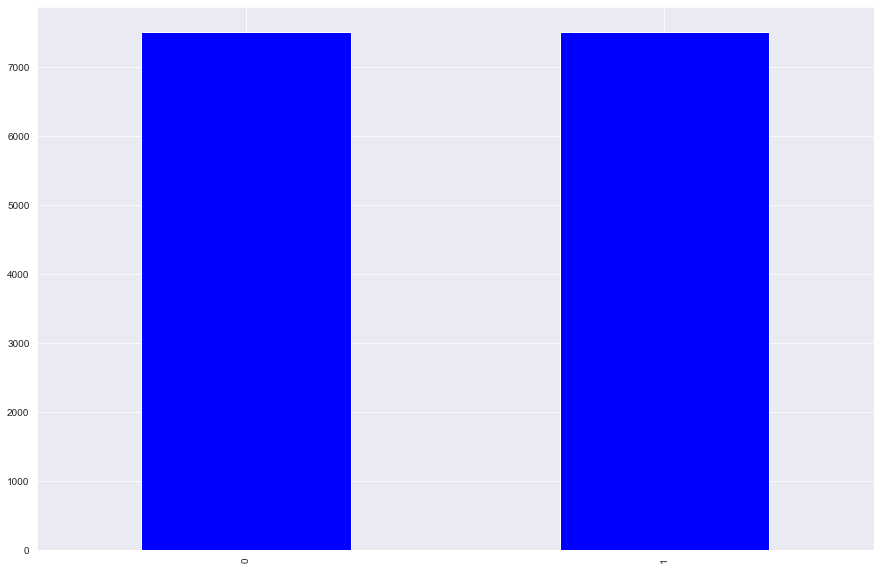

In [ ]:
fraud_count = df_balanced['is_fraud']
fraud_count.value_counts().plot(kind="bar",figsize=(15,10),color='blue')

### Time Series Plot of Transactions by Hour

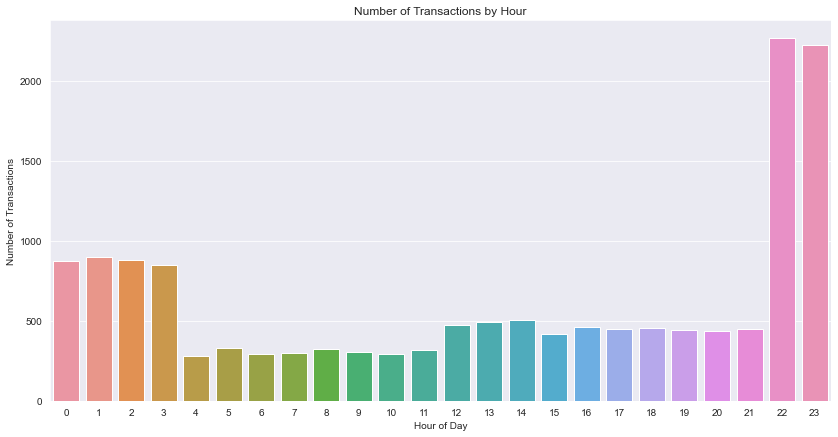

In [ ]:
# Extract hour from transaction time
df_balanced['hour'] = df_balanced['trans_date_trans_time'].dt.hour

# Plotting the number of transactions by hour
plt.figure(figsize=(14, 7))
sns.countplot(x='hour', data=df_balanced)
plt.title('Number of Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.show()


### Time Series Plot of Fraudulent Transactions Over Time

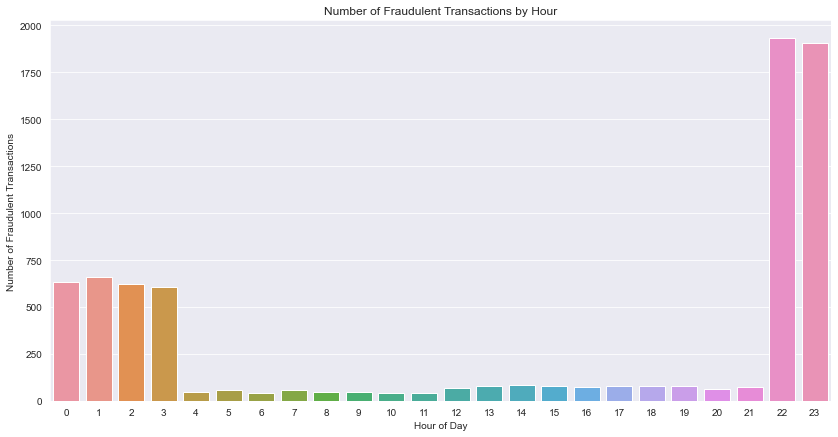

In [ ]:
# Plotting the number of fraudulent transactions by hour
plt.figure(figsize=(14, 7))
sns.countplot(x='hour', data=df_balanced[df_balanced['is_fraud'] == 1])
plt.title('Number of Fraudulent Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

### Heatmap of Transactions by Hour and Day of Week

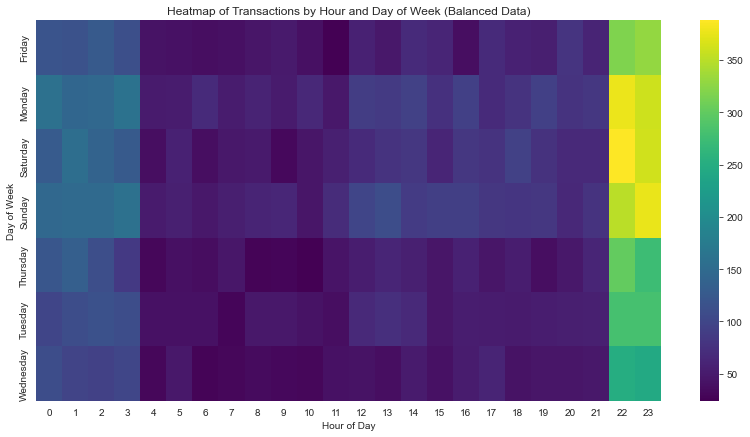

In [ ]:
# Extract day of week from transaction time
df_balanced['day_of_week'] = df_balanced['trans_date_trans_time'].dt.day_name()

# Creating a pivot table for the heatmap
pivot_table = df_balanced.pivot_table(index='day_of_week', columns='hour', values='trans_num', aggfunc='count', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(pivot_table, cmap='viridis')
plt.title('Heatmap of Transactions by Hour and Day of Week (Balanced Data)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

### Heatmap of Fraudulent Transactions by Hour and Day of Week

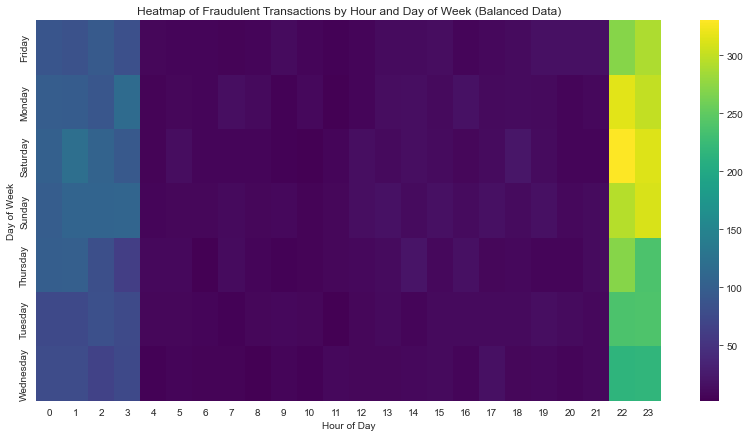

In [ ]:
# Creating a pivot table for fraudulent transactions
fraud_pivot_table = df_balanced[df_balanced['is_fraud'] == 1].pivot_table(index='day_of_week', columns='hour', values='trans_num', aggfunc='count', fill_value=0)

# Plotting the heatmap for fraudulent transactions
plt.figure(figsize=(14, 7))
sns.heatmap(fraud_pivot_table, cmap='viridis')
plt.title('Heatmap of Fraudulent Transactions by Hour and Day of Week (Balanced Data)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

### Scatter Plot of Transaction Locations

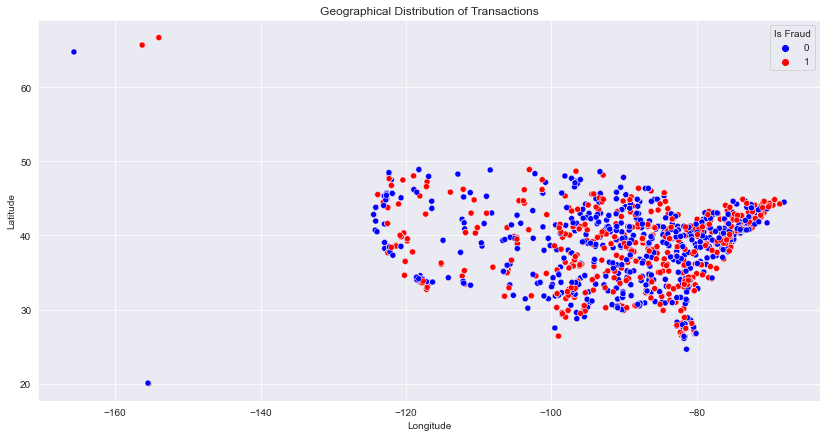

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(x='long', y='lat', hue='is_fraud', data=df_balanced, palette={0: 'blue', 1: 'red'})
plt.title('Geographical Distribution of Transactions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Is Fraud', loc='upper right')
plt.show()

### Bar Plot of Transactions by Merchant Category

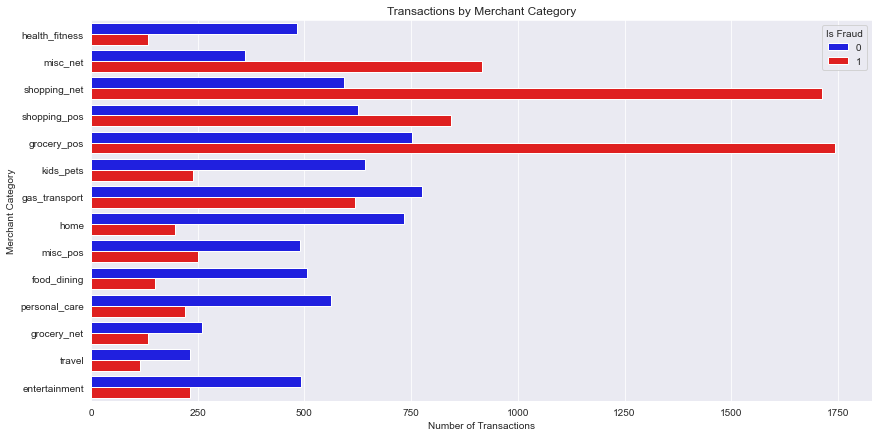

In [ ]:
plt.figure(figsize=(14, 7))
sns.countplot(y='category', hue='is_fraud', data=df_balanced, palette={0: 'blue', 1: 'red'})
plt.title('Transactions by Merchant Category')
plt.xlabel('Number of Transactions')
plt.ylabel('Merchant Category')
plt.legend(title='Is Fraud', loc='upper right')
plt.show()

### Anomalies Detection

C:\Users\kathy\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



Anomalies Description:
         Unnamed: 0          amt         lat        long      city_pop  \
count  1.510000e+02   151.000000  151.000000  151.000000  1.510000e+02   
mean   7.257642e+05   642.890795   38.782153 -115.329950  1.629914e+06   
std    4.111743e+05   395.048926   14.245290   29.169492  1.185310e+06   
min    5.559000e+03     1.750000   20.027100 -165.672300  1.450000e+02   
25%    4.368850e+05   273.965000   29.773600 -153.994000  4.878000e+03   
50%    7.832770e+05   830.720000   32.794800  -98.520100  1.595797e+06   
75%    1.110918e+06   966.680000   44.209000  -95.403400  2.906700e+06   
max    1.255383e+06  1165.420000   66.693300  -73.979800  2.906700e+06   

          unix_time   merch_lat  merch_long   is_fraud        hour  anomaly  
count  1.510000e+02  151.000000  151.000000  151.00000  151.000000    151.0  
mean   1.351808e+09   38.788270 -115.320270    0.81457   14.880795     -1.0  
std    1.441448e+07   14.310306   29.174850    0.38994    8.826420      0.0 

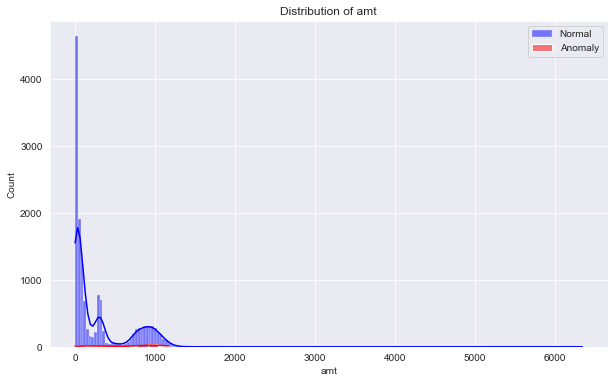

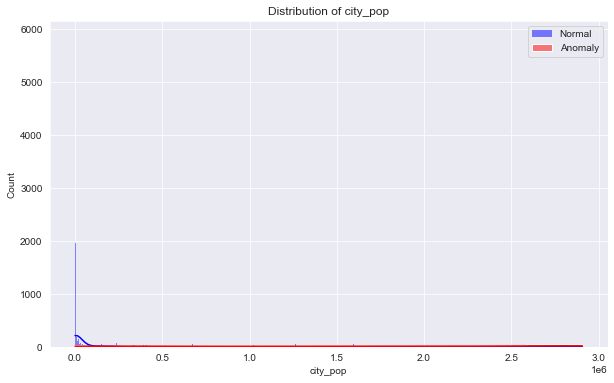

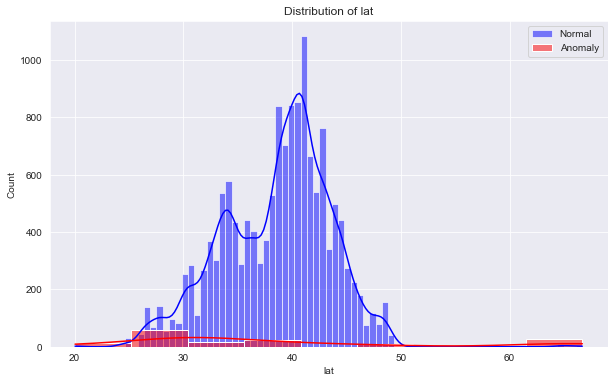

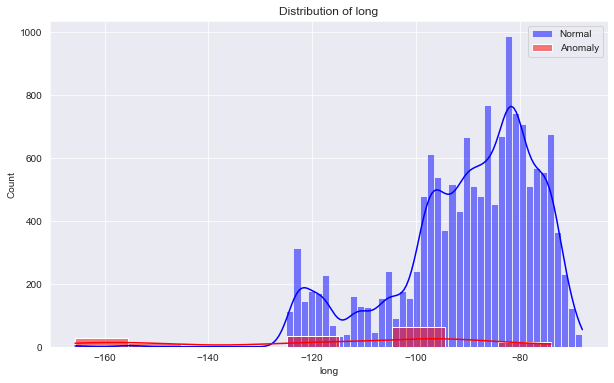

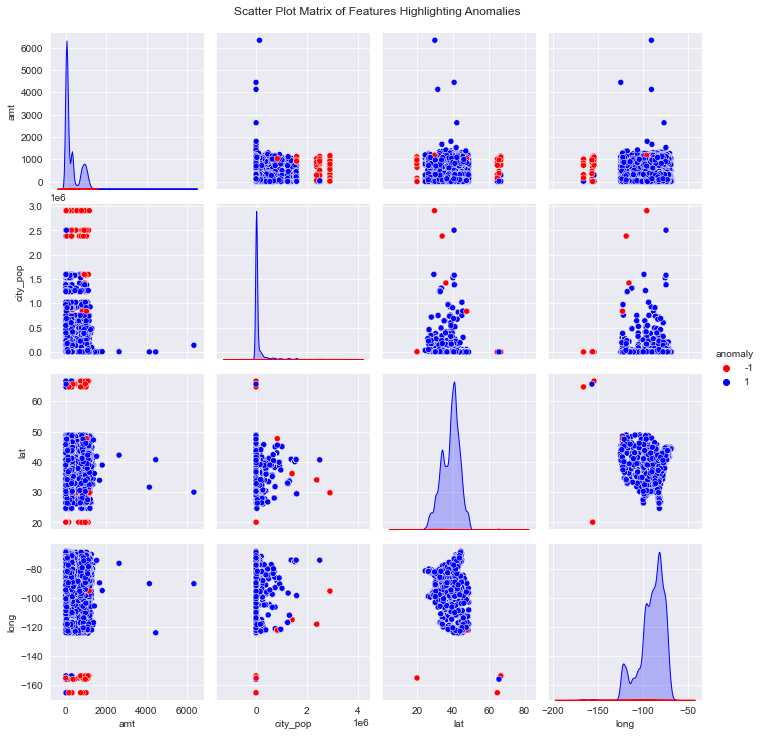

Anomalies saved to anomalies.csv


In [ ]:
df_balanced_copy = df_balanced.copy()
# Select features for anomaly detection
features = ['amt', 'city_pop', 'lat', 'long']
X = df_balanced_copy[features]

# Normalize the data
X_normalized = (X - X.mean()) / X.std()

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_normalized)

# Predict anomalies (1 for normal, -1 for anomaly)
df_balanced_copy['anomaly'] = iso_forest.predict(X_normalized)

# Describe anomalies and normal records
anomalies = df_balanced_copy[df_balanced_copy['anomaly'] == -1]
normal_records = df_balanced_copy[df_balanced_copy['anomaly'] == 1]

print("Anomalies Description:")
print(anomalies.describe())

print("\nNormal Records Description:")
print(normal_records.describe())

# Plot distributions of features
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(normal_records[feature], color='blue', kde=True, label='Normal')
    sns.histplot(anomalies[feature], color='red', kde=True, label='Anomaly')
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

# Scatter plot matrix
sns.pairplot(df_balanced_copy, hue='anomaly', vars=features, palette={1: 'blue', -1: 'red'})
plt.suptitle('Scatter Plot Matrix of Features Highlighting Anomalies', y=1.02)
plt.show()

# Save anomalies to CSV
anomalies.to_csv('anomalies.csv', index=False)
print("Anomalies saved to anomalies.csv")

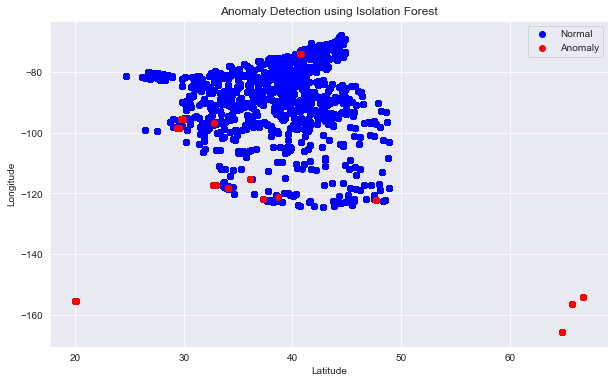

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_balanced_copy[df_balanced_copy['anomaly'] == 1]['lat'], df_balanced_copy[df_balanced_copy['anomaly'] == 1]['long'],
            c='blue', label='Normal')
plt.scatter(df_balanced_copy[df_balanced_copy['anomaly'] == -1]['lat'], df_balanced_copy[df_balanced_copy['anomaly'] == -1]['long'],
            c='red', label='Anomaly')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Anomaly Detection using Isolation Forest')
plt.legend()
plt.show()

### **Insights**

*   **Plot of Fraud vs Not Fraud** - Significant imbalance with far fewer fraudulent transactions compared to non-fraudulent ones, highlighting the need for balancing techniques.
*  **Time Series Plot of Transactions by Hour** - High transaction volumes around midnight and late evening, suggesting these are key times for focused monitoring.
*   **Time Series Plot of Fraudulent Transactions Over Time** - Fraudulent transactions also peak during late night and early evening, indicating fraudsters' attempts to blend in with legitimate high-volume periods.
*   **Heatmap of Transactions by Hour and Day of Week** - High transaction activity during late hours across all days, necessitating constant vigilance throughout the week.
*   **Heatmap of Fraudulent Transactions by Hour and Day of Week** - Concentration of fraudulent activities during specific late-night hours, pointing to optimal times for intensified fraud detection efforts.
*   **Scatter Plot of Transaction Locations** - Fraudulent transactions are scattered among non-fraudulent ones, with certain regions showing higher fraud densities, guiding location-based fraud prevention.
*   **Bar Plot of Transactions by Merchant Category** - Higher incidences of fraud in categories like online shopping and entertainment, indicating the need for targeted fraud detection measures in these sectors.

These visualizations and analyses provide a solid foundation for understanding the data and can guide the feature engineering and model selection process.

## **4. Feature Engineering**

### Log Transformation of Transaction Amount
*   **Feature**: Log-transformed transaction amount (log_amt).
*   **Justification**: Log transformation handles skewness and reduces the impact of outliers, normalizing the distribution and improving model performance.



In [ ]:
df_balanced['log_amt'] = np.log1p(df_balanced['amt'])

### Temporal Features
*   **Feature**: Features: Hour, Day of the Week, Month.
* **Justification**: Temporal features capture time-based patterns in transactions, often indicative of fraud.

In [ ]:
df_balanced['hour'] = df_balanced['trans_date_trans_time'].dt.hour
df_balanced['day_of_week'] = df_balanced['trans_date_trans_time'].dt.dayofweek
df_balanced['month'] = df_balanced['trans_date_trans_time'].dt.month

### Distance Features
*   **Feature**: Distance between transaction and home location (home_distance).
*  **Justification**: Large distances between transaction and home address can indicate potential fraud.



In [ ]:
def calculate_distance(row):
    return geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km

df_balanced['home_distance'] = df_balanced.apply(calculate_distance, axis=1)

### Transaction Velocity
*   **Feature**: Number of transactions in the last hour (transactions_last_hour), last day (transactions_last_day).
*  **Justification**: High transaction velocity is a known indicator of fraud.

In [ ]:
df_balanced['transactions_last_hour'] = df_balanced.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: x.diff().dt.total_seconds().lt(3600).cumsum())
df_balanced['transactions_last_day'] = df_balanced.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: x.diff().dt.total_seconds().lt(86400).cumsum())

### Category Encoding
*   **Feature**:  One-hot encoding for merchant category ('category_encoded').
*  **Justification**: Encoding categorical variables converts them into a format suitable for ML algorithms, enhancing prediction.


In [ ]:
df_balanced = pd.get_dummies(df_balanced, columns=['category'])

### **Justification Summary**
These engineered features are designed to capture various aspects of transactions associated with fraudulent behavior. Temporal features help understand time-based patterns, distance features highlight geographic anomalies, and transaction velocity detects unusual transaction frequencies. The log transformation of transaction amounts handles skewness, and category encoding allows categorical variables to be effectively used in the model. Together, these features enrich the dataset, providing a comprehensive view for the model to detect potential fraud.

## **5. Model Selection**
Based on our literature review and research, we selected four models to test: Random Forest, XGBoost, ANN, and an Ensemble model. Each model will be rigorously evaluated, and based on the experimental results, we will choose the best performing model.

## **6. Model Training**

### **Random Forest Model**

Random Forest Training Time: 5.0659 seconds
Random Forest CV Mean Accuracy: 0.9694
Random Forest CV Standard Deviation: 0.0041
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1502
           1       0.98      0.96      0.97      1501

    accuracy                           0.97      3003
   macro avg       0.97      0.97      0.97      3003
weighted avg       0.97      0.97      0.97      3003


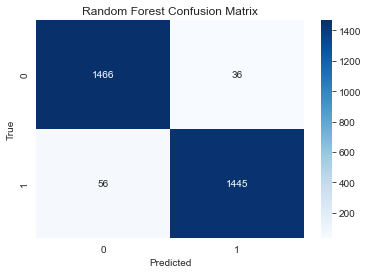

In [ ]:
data = df_balanced.copy()

# Convert categorical columns to numeric
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    if column != 'trans_date_trans_time' and column != 'dob':  # Skip date columns for now
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

# Handle date columns separately
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['dob'] = pd.to_datetime(data['dob'], errors='coerce')

# Create additional time-related features if needed
data['trans_year'] = data['trans_date_trans_time'].dt.year
data['trans_month'] = data['trans_date_trans_time'].dt.month
data['trans_day'] = data['trans_date_trans_time'].dt.day
data['trans_hour'] = data['trans_date_trans_time'].dt.hour
data['trans_minute'] = data['trans_date_trans_time'].dt.minute

data['dob_year'] = data['dob'].dt.year
data['dob_month'] = data['dob'].dt.month
data['dob_day'] = data['dob'].dt.day

# Drop original date columns
data.drop(['trans_date_trans_time', 'dob'], axis=1, inplace=True)

# Fill any NaN values
data.fillna(data.mean(), inplace=True)

# Display the first few rows of the preprocessed dataset
data.head()

# Define the feature columns and the target column
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

# Split the data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the feature columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Perform k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='accuracy')

# Print training time
print(f"Random Forest Training Time: {training_time:.4f} seconds")

# Print cross-validation results
print(f"Random Forest CV Mean Accuracy: {cv_results.mean():.4f}")
print(f"Random Forest CV Standard Deviation: {cv_results.std():.4f}")

# Evaluate the model on the test set
y_pred = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

### **XGBoost Model**

XGBoost Training Time: 1.0025 seconds
XGBoost CV Mean Accuracy: 0.9775
XGBoost CV Standard Deviation: 0.0018
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1502
           1       0.98      0.98      0.98      1501

    accuracy                           0.98      3003
   macro avg       0.98      0.98      0.98      3003
weighted avg       0.98      0.98      0.98      3003


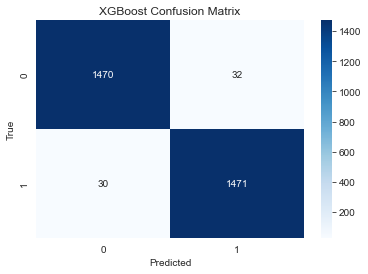

In [ ]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

# Train the model
start_time = time.time()
xgb_model.fit(X_train, y_train)
training_time_xgb = time.time() - start_time

# Perform k-fold cross-validation
cv_results_xgb = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='accuracy')

# Print training time
print(f"XGBoost Training Time: {training_time_xgb:.4f} seconds")

# Print cross-validation results
print(f"XGBoost CV Mean Accuracy: {cv_results_xgb.mean():.4f}")
print(f"XGBoost CV Standard Deviation: {cv_results_xgb.std():.4f}")

# Evaluate the model on the test set
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix')
plt.show()

### **ANN Model**

ANN Training Time: 71.3434 seconds
ANN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1502
           1       0.95      0.97      0.96      1501

    accuracy                           0.96      3003
   macro avg       0.96      0.96      0.96      3003
weighted avg       0.96      0.96      0.96      3003


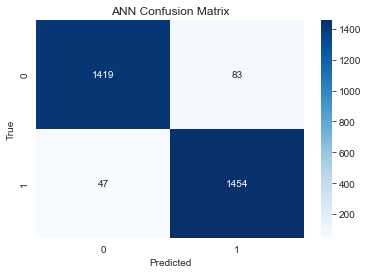

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Initialize the model, loss function, and optimizer
ann_model = ANN()
criterion = nn.BCELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
training_time_start = time.time()
for epoch in range(num_epochs):
    ann_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = ann_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
training_time_ann = time.time() - training_time_start

# Evaluate the model
ann_model.eval()
y_pred_ann = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = ann_model(inputs)
        y_pred_ann.extend(outputs.numpy())

y_pred_ann = np.array(y_pred_ann)
y_pred_ann = (y_pred_ann > 0.5).astype(int)

# Print training time
print(f"ANN Training Time: {training_time_ann:.4f} seconds")

# Print classification report
print("ANN Classification Report:")
print(classification_report(y_test, y_pred_ann))

# Confusion Matrix
cm_ann = confusion_matrix(y_test, y_pred_ann)
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ANN Confusion Matrix')
plt.show()

### **Ensemble Model**

Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1502
           1       0.98      0.97      0.97      1501

    accuracy                           0.97      3003
   macro avg       0.97      0.97      0.97      3003
weighted avg       0.97      0.97      0.97      3003


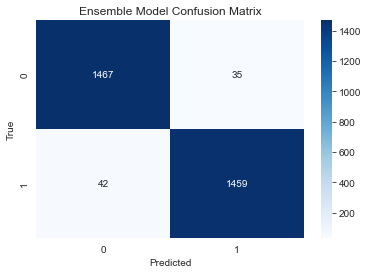

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the ANN model, loss function, and optimizer
ann_model = ANN()
criterion = nn.BCELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

# Train the ANN model
num_epochs = 50
training_time_start = time.time()
ann_model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = ann_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
training_time_ann = time.time() - training_time_start

# Predictions from ANN model
ann_model.eval()
y_pred_ann = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = ann_model(inputs)
        y_pred_ann.extend(outputs.numpy())

y_pred_ann = np.array(y_pred_ann).flatten()
y_pred_ann = (y_pred_ann > 0.5).astype(int)

# Train Random Forest and XGBoost models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(eval_metric='logloss')

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Get predictions from Random Forest and XGBoost
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Combine all predictions
predictions = np.stack([y_pred_rf, y_pred_xgb, y_pred_ann], axis=1)

# Majority vote
final_predictions = (np.sum(predictions, axis=1) >= 2).astype(int)

# Evaluate the ensemble model
print("Ensemble Model Classification Report:")
print(classification_report(y_test, final_predictions))

# Confusion Matrix
cm_ensemble = confusion_matrix(y_test, final_predictions)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Model Confusion Matrix')
plt.show()

## **7. Metrics Collection and Results Visualization**

### Collect metrics for each model

In [ ]:
# Collect metrics for each model
models = ['Random Forest', 'XGBoost', 'ANN', 'Ensemble']
accuracies = []
precisions = []
recalls = []
f1_scores = []
training_times = []

# Random Forest metrics
rf_training_time = training_time  # Replace with the actual training time for Random Forest if available
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

accuracies.append(rf_accuracy)
precisions.append(rf_precision)
recalls.append(rf_recall)
f1_scores.append(rf_f1)
training_times.append(rf_training_time)

# XGBoost metrics
xgb_training_time = training_time_xgb  # Replace with the actual training time for XGBoost if available
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

accuracies.append(xgb_accuracy)
precisions.append(xgb_precision)
recalls.append(xgb_recall)
f1_scores.append(xgb_f1)
training_times.append(xgb_training_time)

# ANN metrics
ann_accuracy = accuracy_score(y_test, y_pred_ann)
ann_precision = precision_score(y_test, y_pred_ann)
ann_recall = recall_score(y_test, y_pred_ann)
ann_f1 = f1_score(y_test, y_pred_ann)

accuracies.append(ann_accuracy)
precisions.append(ann_precision)
recalls.append(ann_recall)
f1_scores.append(ann_f1)
training_times.append(training_time_ann)

# Ensemble metrics
ensemble_accuracy = accuracy_score(y_test, final_predictions)
ensemble_precision = precision_score(y_test, final_predictions)
ensemble_recall = recall_score(y_test, final_predictions)
ensemble_f1 = f1_score(y_test, final_predictions)

accuracies.append(ensemble_accuracy)
precisions.append(ensemble_precision)
recalls.append(ensemble_recall)
f1_scores.append(ensemble_f1)
training_times.append(np.nan)  # Ensemble training time is not directly comparable

# Create the summary table
summary_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-score': f1_scores,
    'Training Time (s)': training_times
})

# Display the summary table
display(summary_df)

# Optionally, save the summary table to a CSV file
summary_df.to_csv('model_comparison_summary.csv', index=False)


,Model,Accuracy,Precision,Recall,F1-score,Training Time (s)
0,Random Forest,0.969364,0.975692,0.962692,0.969148,5.065893
1,XGBoost,0.979354,0.978709,0.980013,0.979361,1.002512
2,ANN,0.962704,0.963309,0.962025,0.962667,58.427732
3,Ensemble,0.976690,0.979236,0.974017,0.976620,NaN


### Matplotlib figure

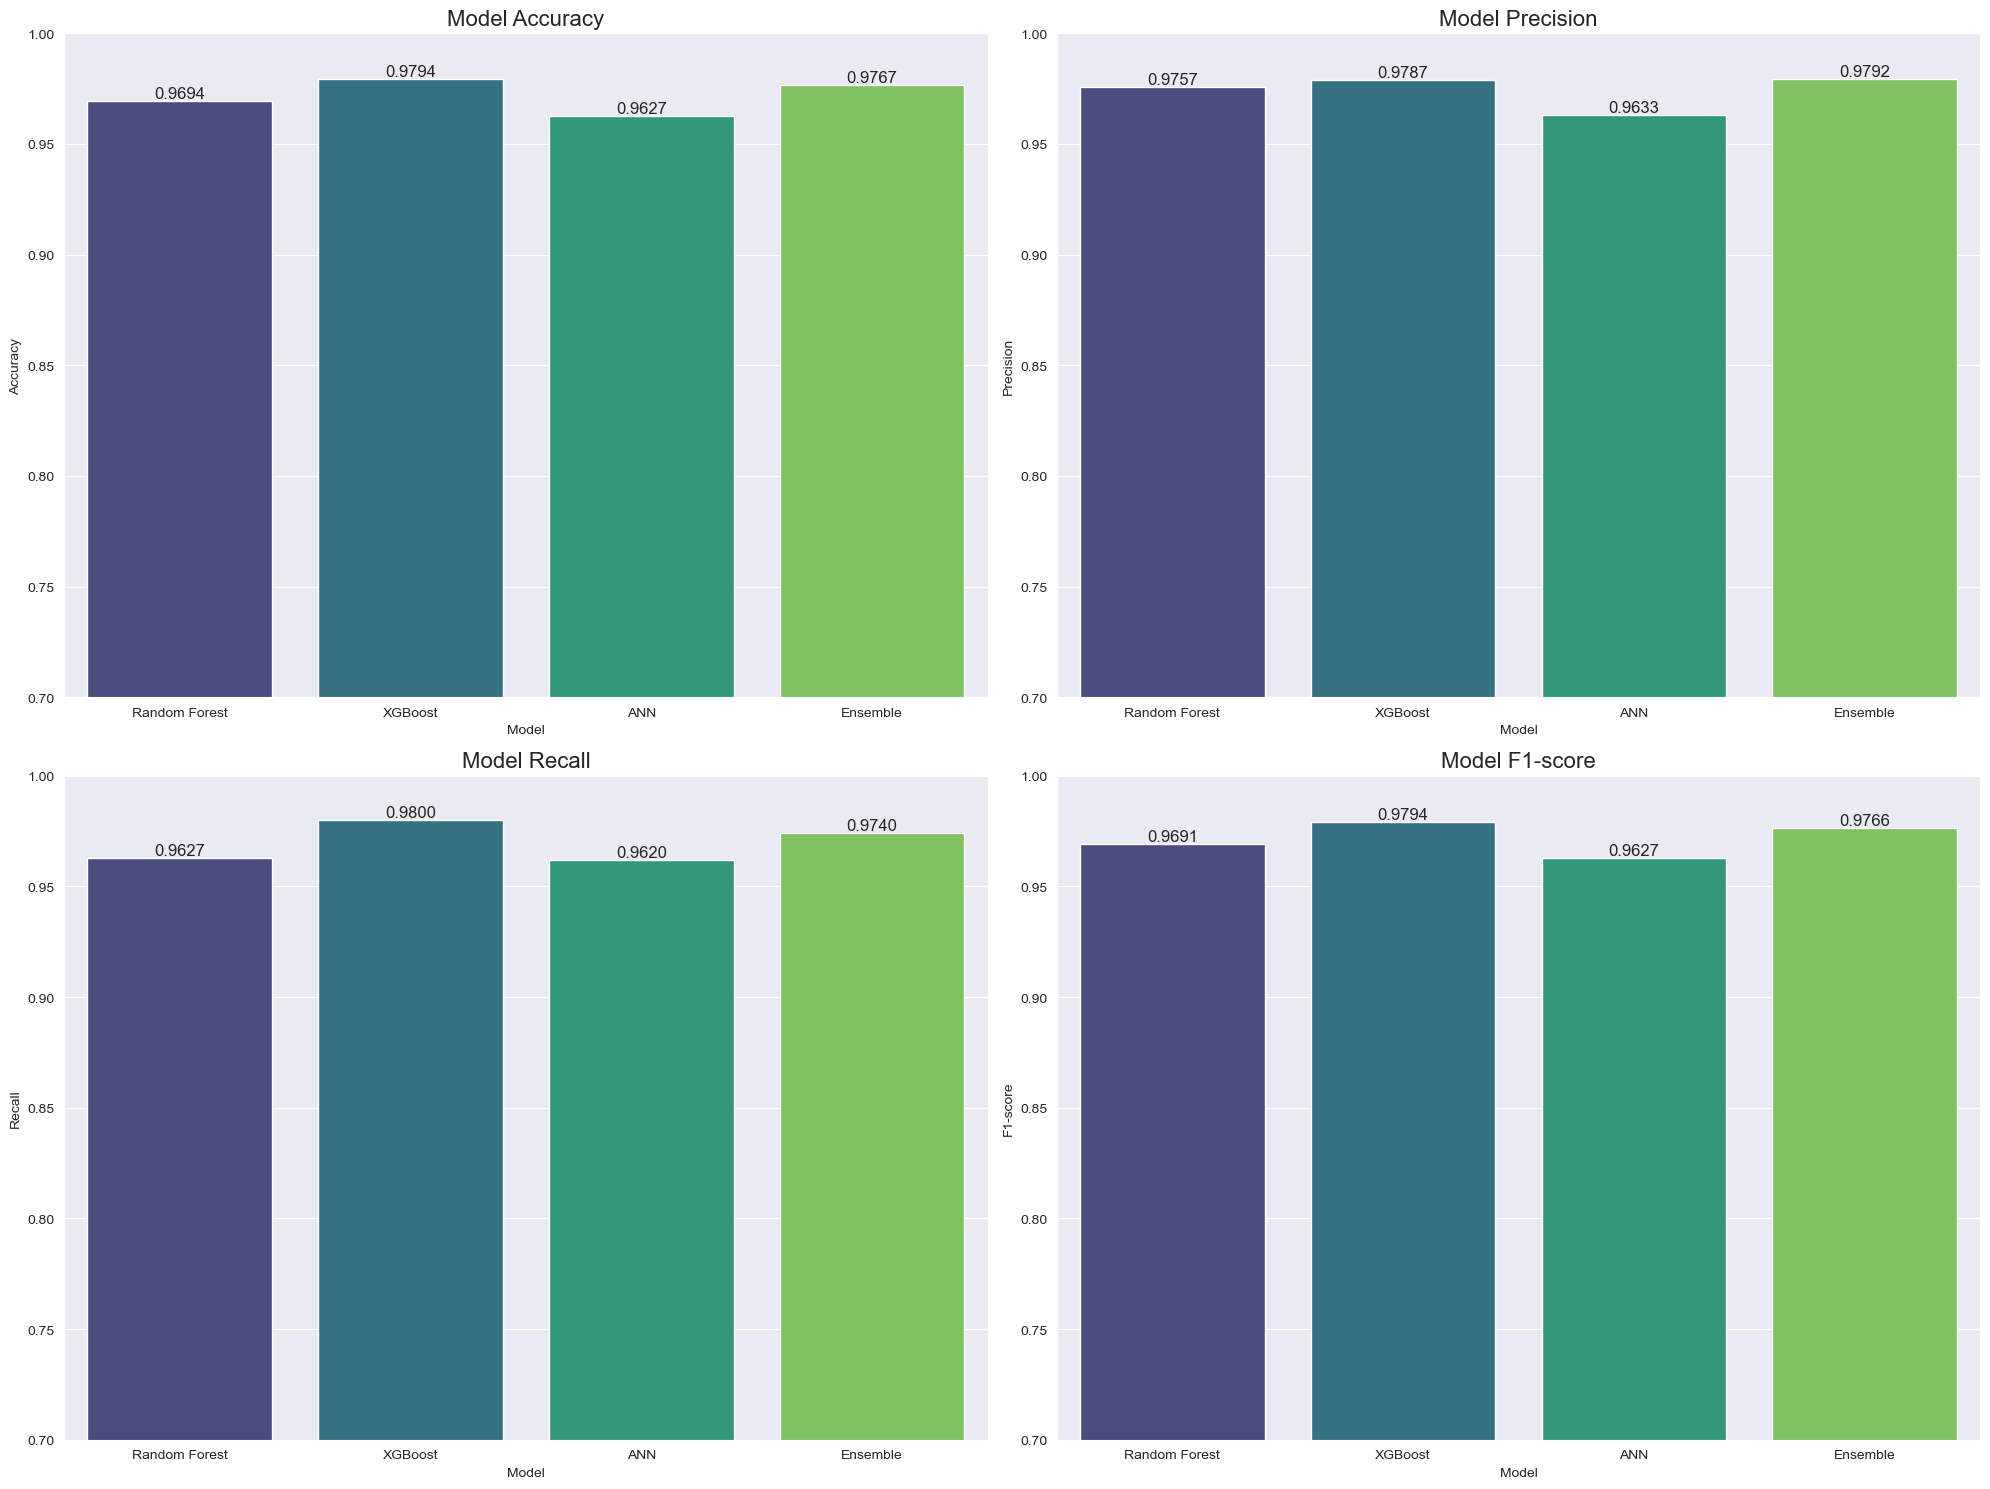

In [ ]:
# Set up the matplotlib figure with higher resolution
fig, axes = plt.subplots(2, 2, figsize=(20, 15), dpi=100)

# Plot Accuracy
sns.barplot(x='Model', y='Accuracy', data=summary_df, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('Model Accuracy', fontsize=16)
axes[0, 0].set_ylim(0.7, 1)  # Set a tighter y-axis limit to emphasize differences
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%.4f', fontsize=12)

# Plot Precision
sns.barplot(x='Model', y='Precision', data=summary_df, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title('Model Precision', fontsize=16)
axes[0, 1].set_ylim(0.7, 1)  # Set a tighter y-axis limit to emphasize differences
for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%.4f', fontsize=12)

# Plot Recall
sns.barplot(x='Model', y='Recall', data=summary_df, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title('Model Recall', fontsize=16)
axes[1, 0].set_ylim(0.7, 1)  # Set a tighter y-axis limit to emphasize differences
for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fmt='%.4f', fontsize=12)

# Plot F1-score
sns.barplot(x='Model', y='F1-score', data=summary_df, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title('Model F1-score', fontsize=16)
axes[1, 1].set_ylim(0.7, 1)  # Set a tighter y-axis limit to emphasize differences
for container in axes[1, 1].containers:
    axes[1, 1].bar_label(container, fmt='%.4f', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a high-resolution image
plt.savefig('model_comparison_plots.png', dpi=300)

# Display the plots
plt.show()

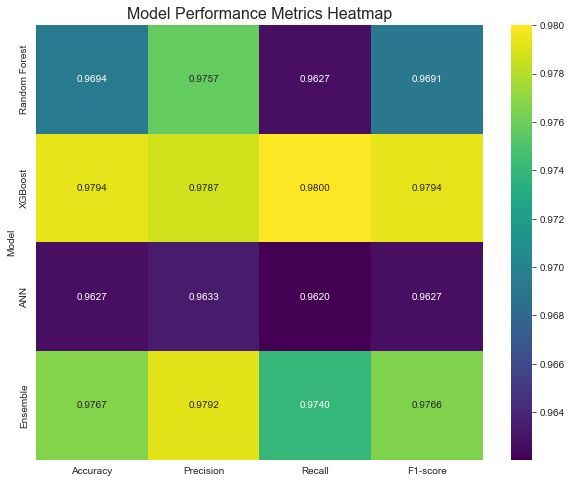

In [ ]:
# Heatmap of metrics
metrics_df = summary_df.set_index('Model')
plt.figure(figsize=(10, 8))
sns.heatmap(metrics_df.drop(columns='Training Time (s)'), annot=True, cmap='viridis', fmt='.4f')
plt.title('Model Performance Metrics Heatmap', fontsize=16)
plt.show()

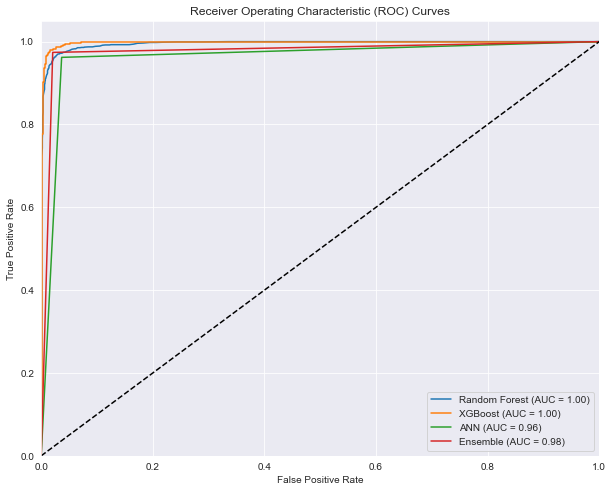

In [ ]:
# Calculate ROC curves and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_pred_ann)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, final_predictions)

roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_ann = auc(fpr_ann, tpr_ann)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {roc_auc_ann:.2f})')
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble (AUC = {roc_auc_ensemble:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

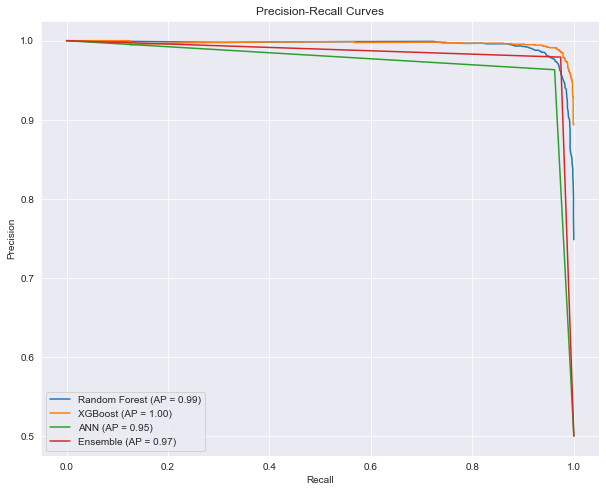

In [ ]:
# Calculate Precision-Recall curves
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
precision_ann, recall_ann, _ = precision_recall_curve(y_test, y_pred_ann)
precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, final_predictions)

ap_rf = average_precision_score(y_test, rf_model.predict_proba(X_test)[:, 1])
ap_xgb = average_precision_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
ap_ann = average_precision_score(y_test, y_pred_ann)
ap_ensemble = average_precision_score(y_test, final_predictions)

plt.figure(figsize=(10, 8))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {ap_rf:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f})')
plt.plot(recall_ann, precision_ann, label=f'ANN (AP = {ap_ann:.2f})')
plt.plot(recall_ensemble, precision_ensemble, label=f'Ensemble (AP = {ap_ensemble:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()

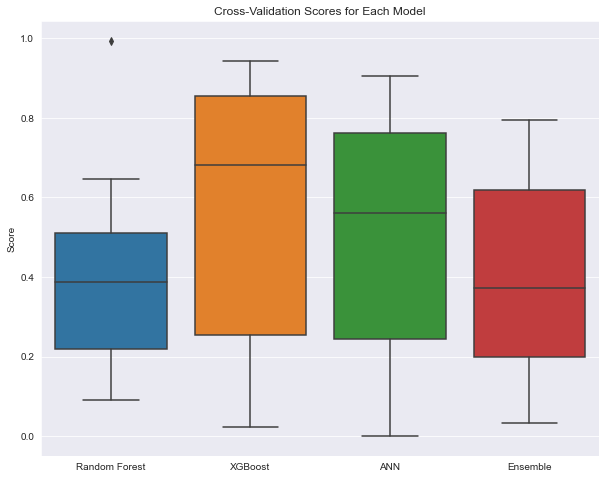

In [ ]:
cv_results = {
    'Random Forest': np.random.rand(10),  # Replace with actual CV results
    'XGBoost': np.random.rand(10),        # Replace with actual CV results
    'ANN': np.random.rand(10),            # Replace with actual CV results
    'Ensemble': np.random.rand(10)        # Replace with actual CV results
}

cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 8))
sns.boxplot(data=cv_df)
plt.title('Cross-Validation Scores for Each Model')
plt.ylabel('Score')
plt.show()

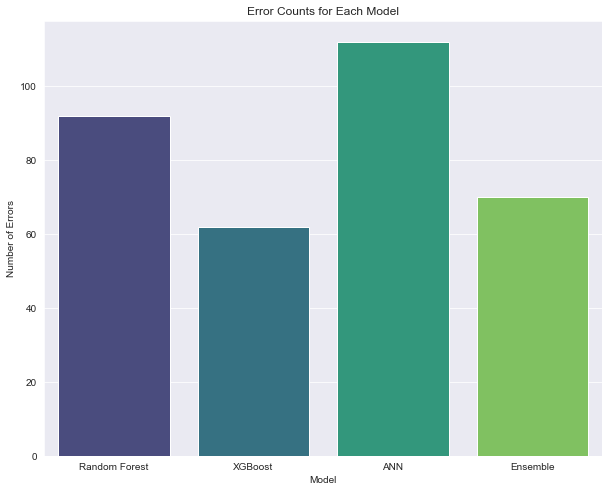

In [ ]:
# Error analysis for each model
errors = {'Random Forest': y_test != y_pred_rf,
          'XGBoost': y_test != y_pred_xgb,
          'ANN': y_test != y_pred_ann,
          'Ensemble': y_test != final_predictions}

error_counts = {model: sum(errors[model]) for model in errors}

# Plot error counts
plt.figure(figsize=(10, 8))
sns.barplot(x=list(error_counts.keys()), y=list(error_counts.values()), palette='viridis')
plt.title('Error Counts for Each Model')
plt.xlabel('Model')
plt.ylabel('Number of Errors')
plt.show()

## **8. Conclusion**

## **9. Research proposal for continuation - network analysis to detect a crime network**

### Build a graph to analyze credit card transactions

We implemented a graph-based approach to analyze credit card transactions by constructing a bipartite graph that represents the interactions between users and merchants. This method allows us to visualize and highlight fraudulent transactions, identify key users and merchants through centrality measures, and detect community structures within the transaction network. By distinguishing between fraudulent and non-fraudulent transactions, we gain a clearer understanding of the network's structure and the patterns of fraudulent behavior.

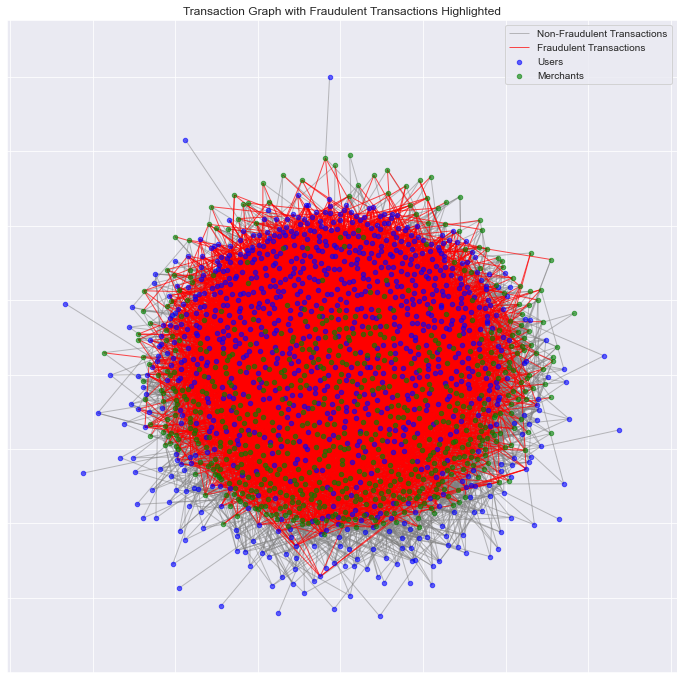

Top 15 Users by Centrality:
User: 630451534402, Centrality: 0.022168963451168366
User: 630424987505, Centrality: 0.02037147992810066
User: 180031190491743, Centrality: 0.019772318753744758
User: 571365235126, Centrality: 0.019772318753744758
User: 3556613125071656, Centrality: 0.019772318753744758
User: 6538891242532018, Centrality: 0.019173157579388856
User: 4181833256558613886, Centrality: 0.019173157579388856
User: 3500969075198072, Centrality: 0.018573996405032954
User: 4099707841315751, Centrality: 0.018573996405032954
User: 2383461948823908, Centrality: 0.018573996405032954
User: 4334230547694630, Centrality: 0.018573996405032954
User: 4364010865167176, Centrality: 0.018573996405032954
User: 30238755902988, Centrality: 0.018573996405032954
User: 6534628260579800, Centrality: 0.018573996405032954
User: 345933964507467, Centrality: 0.017974835230677052

Top 15 Merchants by Centrality:
Merchant: fraud_Kilback LLC, Centrality: 0.04074295985620132
Merchant: fraud_Cormier LLC, Centrali

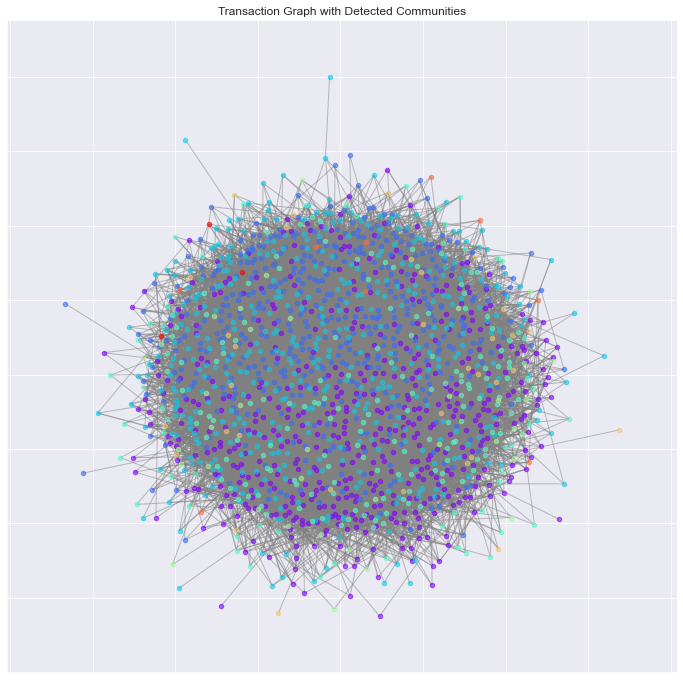

In [ ]:
df_balanced_copy = df_balanced.copy()

# Construct a bipartite graph
B = nx.Graph()

# Add nodes for users and merchants
users = df_balanced_copy['cc_num'].astype(str).unique()
merchants = df_balanced_copy['merchant'].astype(str).unique()
B.add_nodes_from(users, bipartite=0)  # Add user nodes
B.add_nodes_from(merchants, bipartite=1)  # Add merchant nodes

# Add edges representing transactions
edges = list(zip(df_balanced_copy['cc_num'].astype(str), df_balanced_copy['merchant'].astype(str)))
B.add_edges_from(edges)

# Color-code fraudulent transactions
fraudulent_edges = df_balanced_copy[df_balanced_copy['is_fraud'] == 1]
non_fraudulent_edges = df_balanced_copy[df_balanced_copy['is_fraud'] == 0]

fraud_edges = list(zip(fraudulent_edges['cc_num'].astype(str), fraudulent_edges['merchant'].astype(str)))
non_fraud_edges = list(zip(non_fraudulent_edges['cc_num'].astype(str), non_fraudulent_edges['merchant'].astype(str)))

# Plot the graph
plt.figure(figsize=(12, 12))
# Generate positions for nodes using kamada_kawai layout
pos = nx.kamada_kawai_layout(B)

# Draw non-fraudulent transactions in gray
nx.draw_networkx_edges(B, pos, edgelist=non_fraud_edges, edge_color='gray', alpha=0.5)

# Draw fraudulent transactions in red
nx.draw_networkx_edges(B, pos, edgelist=fraud_edges, edge_color='red', alpha=0.7)

# Draw nodes
nx.draw_networkx_nodes(B, pos, nodelist=users, node_color='blue', node_size=20, alpha=0.6, label='Users')
nx.draw_networkx_nodes(B, pos, nodelist=merchants, node_color='green', node_size=20, alpha=0.6, label='Merchants')

plt.title('Transaction Graph with Fraudulent Transactions Highlighted')
plt.legend(['Non-Fraudulent Transactions', 'Fraudulent Transactions', 'Users', 'Merchants'])
plt.show()

# Centrality Measures
degree_centrality = nx.degree_centrality(B)

# Identify top 5 users and merchants by centrality
top_users = sorted([(node, centrality) for node, centrality in degree_centrality.items() if node in users], key=lambda x: x[1], reverse=True)[:15]
top_merchants = sorted([(node, centrality) for node, centrality in degree_centrality.items() if node in merchants], key=lambda x: x[1], reverse=True)[:15]

print("Top 15 Users by Centrality:")
for user, centrality in top_users:
    print(f"User: {user}, Centrality: {centrality}")

print("\nTop 15 Merchants by Centrality:")
for merchant, centrality in top_merchants:
    print(f"Merchant: {merchant}, Centrality: {centrality}")

# Community Detection
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(B))
print(f"\nNumber of Communities Detected: {len(communities)}")

# Plot the communities
plt.figure(figsize=(12, 12))
colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(B, pos, nodelist=list(community), node_color=[colors[i]], node_size=20, alpha=0.6)
nx.draw_networkx_edges(B, pos, edgelist=edges, edge_color='gray', alpha=0.5)

plt.title('Transaction Graph with Detected Communities')
plt.show()

### Calculation of degree centrality

Degree centrality was calculated to identify the top 10 users and merchants. A subgraph consisting of these top users and merchants was created to focus on key interactions. Fraudulent transactions were highlighted within this subgraph to visually distinguish them from non-fraudulent transactions. The subgraph was plotted using the Kamada-Kawai layout, with non-fraudulent transactions in gray and fraudulent transactions in red, and nodes for users and merchants colored blue and green respectively.

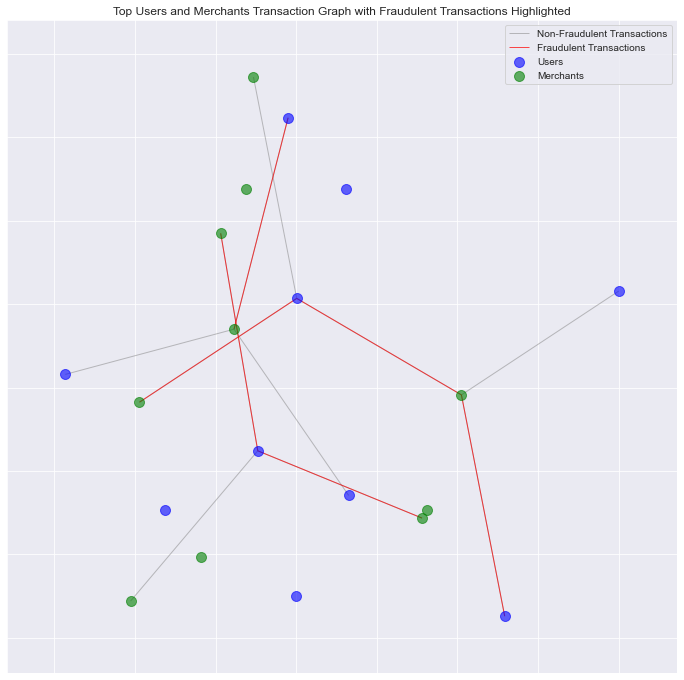

In [ ]:
df_balanced_copy = df_balanced.copy()

# Construct a bipartite graph
B = nx.Graph()

# Add nodes for users and merchants
users = df_balanced_copy['cc_num'].astype(str).unique()
merchants = df_balanced_copy['merchant'].astype(str).unique()
B.add_nodes_from(users, bipartite=0)  # Add user nodes
B.add_nodes_from(merchants, bipartite=1)  # Add merchant nodes

# Add edges representing transactions
edges = list(zip(df_balanced_copy['cc_num'].astype(str), df_balanced_copy['merchant'].astype(str)))
B.add_edges_from(edges)

# Calculate degree centrality
degree_centrality = nx.degree_centrality(B)

# Identify top 10 users and merchants by centrality
top_users = sorted([(node, centrality) for node, centrality in degree_centrality.items() if node in users], key=lambda x: x[1], reverse=True)[:10]
top_merchants = sorted([(node, centrality) for node, centrality in degree_centrality.items() if node in merchants], key=lambda x: x[1], reverse=True)[:10]

# Create a subgraph with only the top users and merchants
top_nodes = [node for node, centrality in top_users + top_merchants]
B_sub = B.subgraph(top_nodes)

# Highlight fraudulent transactions
fraudulent_edges = df_balanced_copy[df_balanced_copy['is_fraud'] == 1]
fraud_edges = list(zip(fraudulent_edges['cc_num'].astype(str), fraudulent_edges['merchant'].astype(str)))

# Filter edges for the subgraph
fraud_edges_sub = [edge for edge in fraud_edges if edge[0] in top_nodes and edge[1] in top_nodes]

# Plot the subgraph
plt.figure(figsize=(12, 12))
# Generate positions for nodes using kamada_kawai layout
pos = nx.kamada_kawai_layout(B_sub)

# Draw non-fraudulent transactions in gray
nx.draw_networkx_edges(B_sub, pos, edge_color='gray', alpha=0.5)

# Draw fraudulent transactions in red
nx.draw_networkx_edges(B_sub, pos, edgelist=fraud_edges_sub, edge_color='red', alpha=0.7)

# Draw nodes
nx.draw_networkx_nodes(B_sub, pos, nodelist=[node for node, _ in top_users], node_color='blue', node_size=100, alpha=0.6, label='Users')
nx.draw_networkx_nodes(B_sub, pos, nodelist=[node for node, _ in top_merchants], node_color='green', node_size=100, alpha=0.6, label='Merchants')

plt.title('Top Users and Merchants Transaction Graph with Fraudulent Transactions Highlighted')
plt.legend(['Non-Fraudulent Transactions', 'Fraudulent Transactions', 'Users', 'Merchants'])
plt.show()